# Exploring a Nowcast Time Series from ERDDAP

This notebook contains discussion and examples of accessing a time series of
results from the Salish Sea NEMO Nowcast system from the ERDDAP server.
The time series of interest span several days of nowcast runs,
so ERDDAP provides a more convenient way of accessing the results than building
the time series by loading several single day nowcast results file.
We'll use the [xarray](http://xarray.pydata.org/) to demonstrate it powerful
time period selection,
and built-in plotting features that facilitate quick dataset visualization.
Topics include:

* 

For an introduction to accessing nowcast results datasets from our ERDDAP server,
please see [Exploring netCDF Datasets from ERDDAP.ipynb](https://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Exploring%20netCDF%20Datasets%20from%20ERDDAP.ipynb).

For an introduction to the xarray package,
please see [Exploring netCDF Datasets Using xarray.ipynb](https://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/tools/raw/tip/analysis_tools/Exploring%20netCDF%20Datasets%20Using%20xarray.ipynb).

This notebook assumes that you are working in Python 3.
If you don't have a Python 3 environment set up,
please see our
[Anaconda Python Distribution](http://salishsea-meopar-docs.readthedocs.org/en/latest/work_env/anaconda_python.html)
docs for instructions on how to set one up.

`xarray` and some of the packages that it depends on are not included in the default Anaconda
collection of packages,
so you may need to installed them explicitly:
```
$ conda install xarray netCDF4 bottleneck
```

[`bottleneck`](https://github.com/kwgoodman/bottleneck)
is a package that speeds up NaN-skipping and rolling window aggregations.

If you are using a version of Python earlier than 3.5
(check with the command `python --version`),
you should also install [`cyordereddict`](https://github.com/shoyer/cyordereddict)
to speed internal operations with xarray data structures.
It is not required for Python ≥3.5 because `collections.OrderedDict` has been rewritten
in C,
making it even faster than `cyordereddict`.

In [26]:
import matplotlib.pyplot as plt
import seaborn
import xarray as xr

In [3]:
%matplotlib inline

In [4]:
tracers = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DTracerFields1hV1')
weather = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

In [14]:
surf_temp_ts = (
    tracers.temperature
    .sel(depth=0.5, method='nearest')
    .sel(gridY=350, gridX=250)
    .sel(time=slice('2016-04-12 12:30:00', '2016-04-15 12:30:00'))
)

In [15]:
print(surf_temp_ts)

<xarray.DataArray 'temperature' (time: 73)>
array([ 9.25489235,  9.23990822,  9.22343826,  9.24158955,  9.25886154,
        9.26789761,  9.28096581,  9.31079292,  9.3117981 ,  9.44995499,
        9.47854614,  9.40759563,  9.36821365,  9.36555862,  9.370224  ,
        9.34206295,  9.32940865,  9.31818962,  9.31189156,  9.30025578,
        9.29597473,  9.26408863,  9.2766943 ,  9.23858166,  9.22358036,
        9.23360062,  9.2329731 ,  9.24096584,  9.27601528,  9.29912567,
        9.36781502,  9.4630003 ,  9.36896515,  9.33247471,  9.41092205,
        9.42438602,  9.40737057,  9.38601685,  9.36913013,  9.36316776,
        9.33243847,  9.34422779,  9.33980656,  9.33363628,  9.32870102,
        9.3315134 ,  9.31691647,  9.30960655,  9.30206203,  9.29469109,
        9.28893089,  9.28549099,  9.30699062,  9.3746233 ,  9.49199581,
        9.58913136,  9.5932312 ,  9.51420212,  9.40592575,  9.49716282,
        9.51946449,  9.47733974,  9.4493351 ,  9.41999722,  9.38685894,
        9.35888004, 

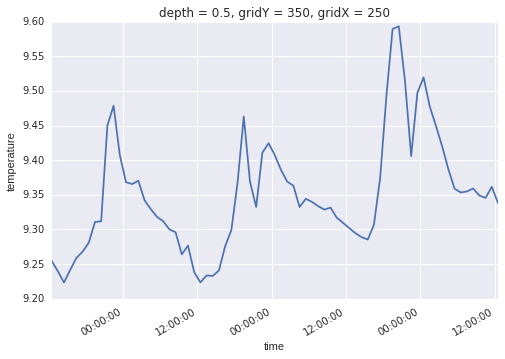

In [27]:
surf_temp_ts.plot()

In [23]:
surf_temp_ts.depth.values = surf_temp_ts.depth.values.round(3)

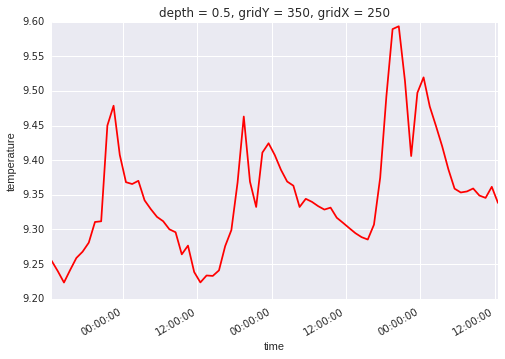

In [29]:
fig, ax = plt.subplots()
surf_temp_ts.plot(ax=ax, color='r')